# **Random Forest**

### Why Random Forest?
As initial model, I've choosen the Random Forest classier due to its robustness and performance advantages:
- it exploit bagging to aggregate multiple decision trees, which reduce variance and helps prevent overfitting.
- each tree is built on a small subset of the features, increasing the diversity among trees -> improves generalization.

### Data Preparation
This part consist of what we did in the first notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

#### DATA PREPARATION

train_features = df_train.columns.tolist()
test_features = df_test.columns.tolist()
features_toremove =  list(set(train_features) - set(test_features) - {'sii'})

del df_train['id']
for col in features_toremove:
    del df_train[col]
df_train.dropna(subset=['sii'], inplace=True)

physical_measures_df = pd.read_csv('data/physical_measures.csv')

df_train = df_train.merge( physical_measures_df, on=['Basic_Demos-Age', 'Basic_Demos-Sex'], suffixes=('', '_avg'))
cols = ['Physical-BMI','Physical-Height','Physical-Weight','Physical-Waist_Circumference','Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP']
tot_nan_phys = df_train[cols].isna().all(axis=1)

for col in cols:
    df_train.loc[tot_nan_phys, col] = df_train.loc[tot_nan_phys, f"{col}_avg"]
    del df_train[f"{col}_avg"]


X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

is_numerical = np.array([np.issubdtype(dtype, np.number) for dtype in X.dtypes])  
numerical_idx = np.flatnonzero(is_numerical) 
new_X_train = X_train.iloc[:, numerical_idx]
new_X_test = X_test.iloc[:, numerical_idx]


scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)

scaled_train = scaler.fit_transform(new_X_train)
X_array = imputer.fit_transform(scaled_train)
X_array = scaler.inverse_transform(X_array)
new_X_train = pd.DataFrame(X_array, columns=new_X_train.columns, index=new_X_train.index) # convert into a dataframe since X_array is of type ndarray

scaled_test = scaler.fit_transform(new_X_test)
X_array = imputer.fit_transform(scaled_test)
X_array = scaler.inverse_transform(X_array)
new_X_test = pd.DataFrame(X_array, columns=new_X_test.columns, index=new_X_test.index)

categorical_idx = np.flatnonzero(is_numerical==False)
categorical_X_train = X_train.iloc[:, categorical_idx]
categorical_X_test = X_test.iloc[:, categorical_idx]

imputer = SimpleImputer(strategy='most_frequent')
X_array = imputer.fit_transform(categorical_X_train)
categorical_X_train = pd.DataFrame(X_array, columns=categorical_X_train.columns, index=categorical_X_train.index)

X_array = imputer.fit_transform(categorical_X_test)
categorical_X_test = pd.DataFrame(X_array, columns=categorical_X_test.columns, index=categorical_X_test.index)


oh = OneHotEncoder(sparse_output=False)

oh.fit(categorical_X_train)
encoded = oh.transform(categorical_X_train)

for i, col in enumerate(oh.get_feature_names_out()):
    new_X_train = new_X_train.copy()
    new_X_train[col] = encoded[:, i]

oh.fit(categorical_X_test)
encoded = oh.transform(categorical_X_test)

for i, col in enumerate(oh.get_feature_names_out()):
    new_X_test = new_X_test.copy()
    new_X_test[col] = encoded[:, i]

### Tuning the HyperParameter
We have the Random Forest model from the previous notebook as basic model, let's do some refinement and see if it's possible to improve our accuracy. <br>
To do this we will tune the hyperparameter of the Random Forest model.<br>
Usually the validation set is used to do this, indeed the validation set is used to simulate an unseen test set on which it's possible to tune/validate the algorithm's parameters. <br>
We are going to use a k-fold cross-validation that tune the hyperparameters automatically.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

base_model = RandomForestClassifier()
parameters = { 'n_estimators': [50, 100, 200],
    'max_leaf_nodes': [50, 80, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
tuned_model.fit(new_X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Best Score: 0.615
Best Params:  {'bootstrap': True, 'max_depth': 20, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'n_estimators': 50}
Test Accuracy: 0.597


We got a more accurate model.<br>

Let's investigate better the performance using a Confusion Matrix. This is useful to understand better the classes, specifically:
- Which are the classes that have more instances (important to understand the classes that influences more the model)
- Which are the classes that the model predict better

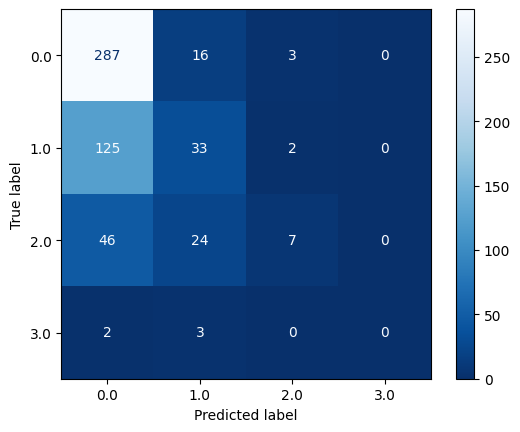

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

We can see that the classes that the model predict better are the one with more instances, this is normal since the goal of the predictor is to predict correctly more instances as possible and not to predict classes in a balanced way. <br>
Indeed class 0 has the most of the instances, so it has a larger impact on the final measure. <br>
The problem we can see is that the predictor classify a lot of instances as class 0, over the 80% of the instances. This number is way too high compared to the baseline accuracy that represent the percentage of instances of class 0 compared to the total (that was 56%). <br>
We want to mitigate bias toward the dominant class, to do this we will give to the classes a weight inversely proportional to their frequency.

In [38]:
base_model = RandomForestClassifier(class_weight='balanced') # give weight to the class that are inversely proportional to frequency
parameters = { 'n_estimators': [50, 100, 200],
    'max_leaf_nodes': [50, 80, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
tuned_model.fit(new_X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Best Score: 0.575
Best Params:  {'bootstrap': True, 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_split': 10, 'n_estimators': 50}
Test Accuracy: 0.573


Now we have a slighty lower accuracy, but this is normal since, we are giving more importance to classes with less instances. <br>
Let's see this time how the prediction are distribuited on the possible classes:

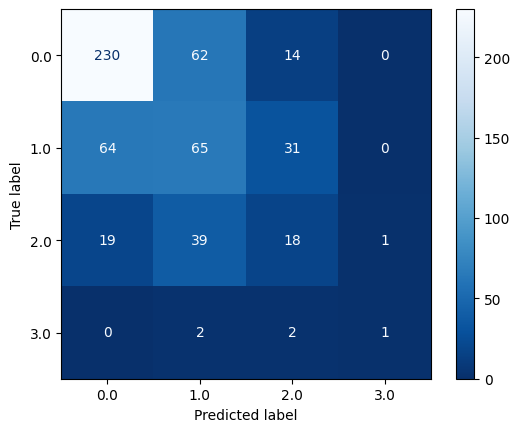

In [39]:
ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

The predictions are now more balanced across the classes, indeed the classifier is able to also predict instances that are not from class 0. <br>
In the next sections we will use this last model since it has a good accuracy and it's more balanced.

### Feature Subset Selection
Now we have a model that uses all the features present in the dataset, to enhance efficiency and reduce overfitting, we will now select a subset of the most informative features. <br>
In this way we also reduce the risks of random collection and the generalization error of the model.

We will start by investigating the importance of the features:

['Physical-Height', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']


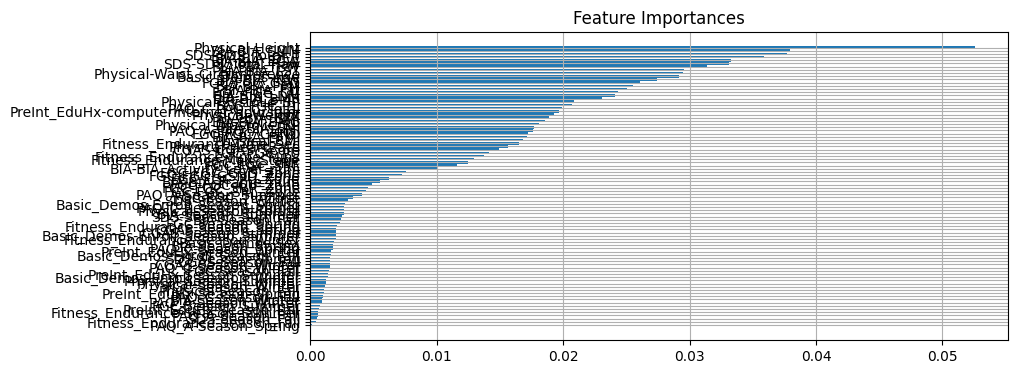

In [40]:
feature_names = new_X_train.columns.tolist()

important_features = [name for name, importance in zip(feature_names, tuned_model.best_estimator_.feature_importances_) if importance > 0.03]
print(important_features)

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(new_X_train.shape[1]), sorted(tuned_model.best_estimator_.feature_importances_)[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(new_X_train.shape[1]))
ax.set_yticklabels(np.array(feature_names)[np.argsort(tuned_model.best_estimator_.feature_importances_)[::-1]])
ax.invert_yaxis() 
ax.grid()

We can see that this time the most important features are age, height and the one relative to:
- Bio-electric Impedance Analysis: measure of key body composition elements, including BMI, fat, muscle, and water content.
- Sleep Disturbance Scale:  scale to categorize sleep disorders in children <br>

For the selection of the features I will perform a Recursive Elimination in a cross-validation loop. <br>
It's a quite slow method but it's more precise than the embedded approach since it removes few features at time so it's less affected from dependencies and correlation. <br>
This time I will create the classifier with the hyperparameter tuned as it was in the last model with balanced class weight, since we have already computed the cross-validation.

In [ ]:
from sklearn.feature_selection import RFECV

base_model = RandomForestClassifier(class_weight='balanced', bootstrap=True, max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=50)
selector = RFECV(base_model, step=5, cv=5, scoring='accuracy', n_jobs=-1)
selector.fit(new_X_train, y_train)
X_train_subset = new_X_train.iloc[:, selector.support_]
X_test_subset = new_X_test.iloc[:, selector.support_]
print(new_X_train.shape[1])
print(X_train_subset.shape[1])
X_train_subset.columns.to_list()

# base_model = RandomForestClassifier(class_weight='balanced')
# parameters = { 'n_estimators': [50, 100, 200],
#     'max_leaf_nodes': [50, 80, 100],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'bootstrap': [True, False]
#     }
# tuned_model = GridSearchCV(base_model, parameters, cv=5, n_jobs=-1)
base_model.fit(X_train_subset, y_train)
test_acc = accuracy_score(y_true = y_test, y_pred = base_model.predict(X_test_subset) )
print("Test Accuracy: {:.3f}".format(test_acc) )

88
53
Test Accuracy: 0.573


The number of features is a lot lower, indeed now we have 53 features. We can also see that even if we have a lower number of features, the accuracy of the model is stable. <br>
The Confusion Matrix of this new model composed only by the most important features is:

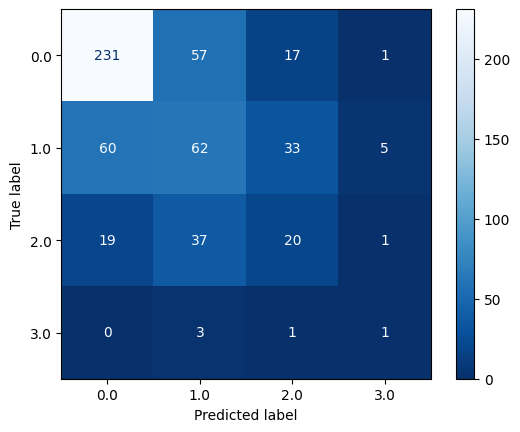

In [44]:
ConfusionMatrixDisplay.from_estimator(
    estimator=base_model,
    X=X_test_subset, y=y_test,
    cmap = 'Blues_r')

The confusion matrix is quite similiar to the one of the tuned full model, but this time we have a more robust and efficient solution since we have a lower risk of overfitting. <br>
We can also see which are the features that we have kept:

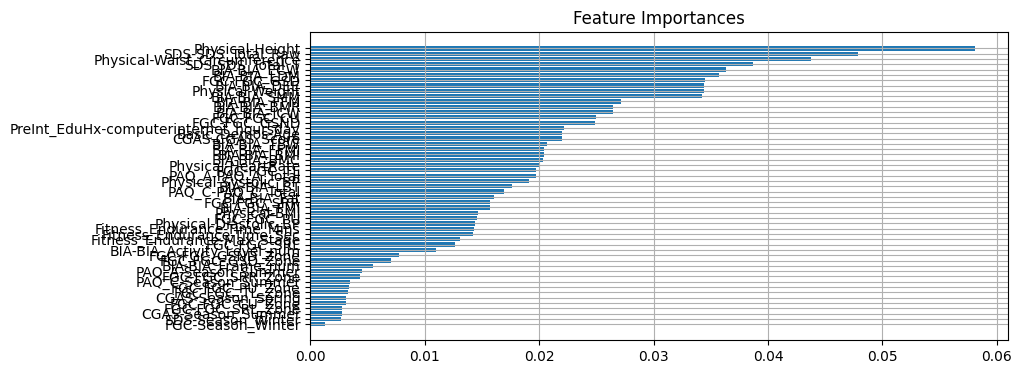

In [45]:
subset_feature_names = X_train_subset.columns.tolist()

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(X_train_subset.shape[1]), sorted(base_model.feature_importances_)[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(X_train_subset.shape[1]))
ax.set_yticklabels(np.array(subset_feature_names)[np.argsort(base_model.feature_importances_)[::-1]])
ax.invert_yaxis() 
ax.grid()

The most important features are all numerical, indeed as we could immagine the categorical features wheren't that useful for the prediction since they where just informing on in what season the measurement where made. <br>
The most important features are the one related to physical measures, sleep disturbance scale and bio-electric impedance analysis, so they don't differ a lot from the most important for the full model. A difference that we can notice is that the importance of the age decreased, probabily because it was more relavant if in combination with one of the removed features.

### Investigating Problematic Instances
We are now interested in investigating the instances that are reflected as the most wrong predictions. <br>
For most wrong predictions we mean the instances that the model thought were of a class label, but are of another.

In [ ]:
y_proba = base_model.predict_proba(X_test_subset) # for each instances get the probability that it belongs to each class
confidence = np.max(y_proba, axis=1) # we get with what probability an instance was mapped to a class label
results_df = pd.DataFrame({
    'true_label': y_test,
    'pred_label': base_model.predict(X_test_subset),
    'confidence': confidence
})
results_df['correct'] = results_df['true_label'] == results_df['pred_label']
results_df['index'] = y_test.index

most_wrong = results_df[~results_df['correct']].sort_values(by='confidence', ascending=False).head(500)
print(most_wrong.head(10))

      true_label  pred_label  confidence  correct  index
2181         1.0         0.0    0.792047    False   2181
1657         1.0         0.0    0.775731    False   1657
32           2.0         0.0    0.704582    False     32
1179         1.0         0.0    0.690784    False   1179
2470         1.0         0.0    0.687808    False   2470
1133         2.0         0.0    0.686100    False   1133
891          1.0         0.0    0.679497    False    891
1263         1.0         0.0    0.675272    False   1263
1106         1.0         0.0    0.656955    False   1106
498          1.0         0.0    0.639105    False    498


We can see that the instances that were most confident about their results but still predict wrongly are the one that were classified as label 0, but was of label 1.

We will now see how these instances behave compared to the instances in general. <br>
To do this we will take some of the most important features and plot the distribution of the instances to see if they can give us some insight.

In [ ]:
feature_names = new_X_train.columns.tolist()

important_features = [name for name, importance in zip(feature_names, tuned_model.best_estimator_.feature_importances_) if importance > 0.035]
print(important_features)


['Physical-Height', 'BIA-BIA_DEE', 'BIA-BIA_SMM', 'SDS-SDS_Total_T']


4

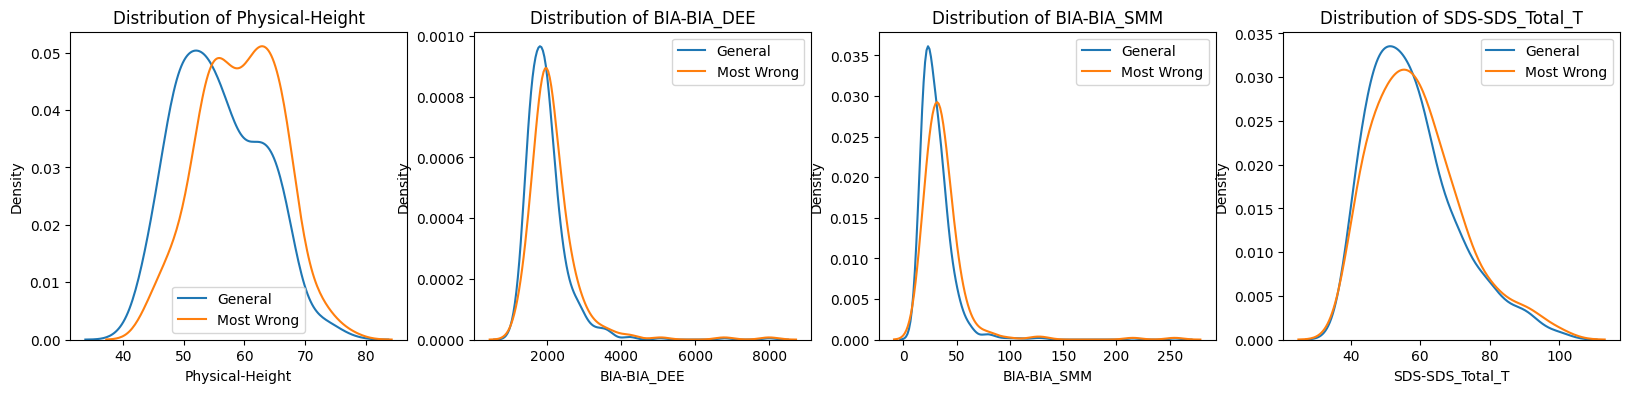

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i in range(len(important_features)):
    sns.kdeplot(X_test_subset[important_features[i]], label='General', ax=ax[i])
    sns.kdeplot(X_test_subset.loc[most_wrong['index']][important_features[i]], label='Most Wrong', ax=ax[i])

    ax[i].legend()
    ax[i].set_xlabel(important_features[i])
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Distribution of {important_features[i]}')

In [68]:
most_correct = results_df[results_df['correct']].sort_values(by='confidence', ascending=False).head(500)
print(most_correct.head(10))

      true_label  pred_label  confidence  correct  index
1647         0.0         0.0    0.856166     True   1647
2123         0.0         0.0    0.838477     True   2123
1087         0.0         0.0    0.807711     True   1087
1983         0.0         0.0    0.797255     True   1983
1213         0.0         0.0    0.793732     True   1213
2151         0.0         0.0    0.779621     True   2151
2172         0.0         0.0    0.778234     True   2172
1237         0.0         0.0    0.777333     True   1237
1001         0.0         0.0    0.776236     True   1001
1626         0.0         0.0    0.774302     True   1626


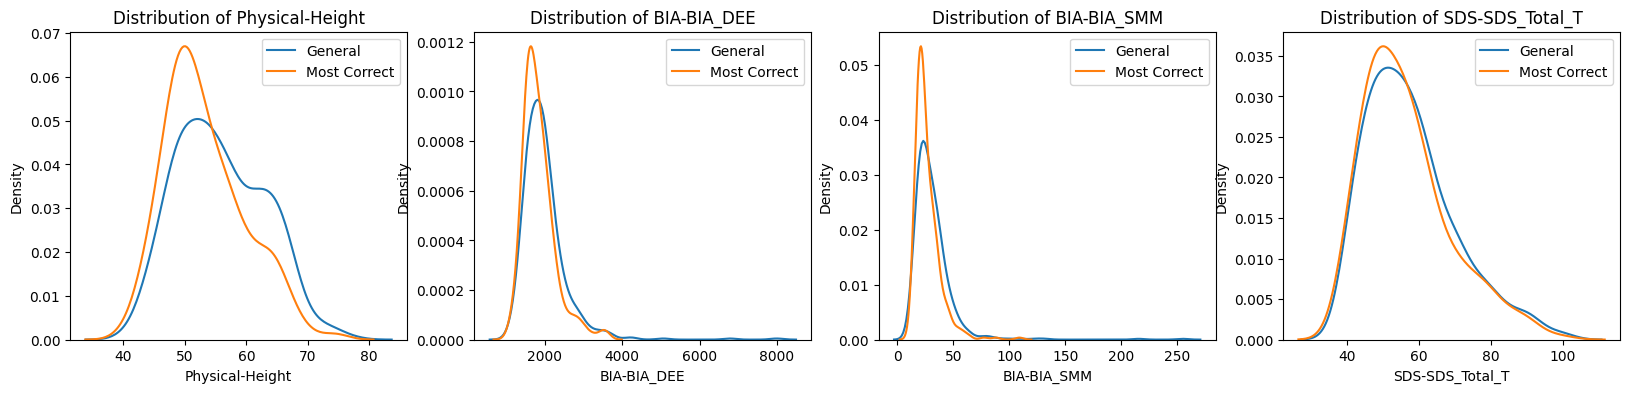

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i in range(len(important_features)):
    sns.kdeplot(X_test_subset[important_features[i]], label='General', ax=ax[i])
    sns.kdeplot(X_test_subset.loc[most_correct['index']][important_features[i]], label='Most Correct', ax=ax[i])

    ax[i].legend()
    ax[i].set_xlabel(important_features[i])
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Distribution of {important_features[i]}')